In [1]:

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import time
from math import pi, sinh, sin,sqrt,floor
from pyevtk.hl import gridToVTK 


# from sympy import symbols, sin, sinh, pi, latex  - commented as other functions reading sin, etc. as symbols when 
# calculating


## Solves steady state momentum equation

velocity prescribed at inlet. Neumann condition at outlet

In [2]:
def CFD(Lx,Ly,Nx,Ny,vis,vl,vr,vt,vb,rho,gradP):
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    #Calculate coefficients
    #east and west face coefficients equal i.e. along x direction
    ax = vis*dy/dx
    #north and south face coefficients equal i.e. along y direction
    ay = vis*dx/dy
    
    ap = -2*(ax+ay)
    
    dim = 2 #2 dimensions (x and y)
    # total number of cells
    M = int(Nx*Ny)
    #Initialise temperature vector
    v = np.zeros((dim*M, 1))
    
    #Initialise source vector
    b = np.zeros((dim*M, 1))
    
    #Initialise coefficient matrix
    A = np.zeros((dim*M, dim*M))
    
    kP = (1/rho)*gradP*dx*dy
#     print(kP)
    # 6 coeffs on each corner + 8 coeffs on each cell attached to a side
    #+10 coeffs on each internal cell
    internalandcorner = 6*4+10*(Nx-2)*(Ny-2)
    sides =  8*(2*Nx+2*Ny-8)
    numNonZeros = internalandcorner+sides
    
    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))
    #get indices of corner cells
    botright = 2*(Nx-1)
    topleft = 2*(Nx*(Ny-1))
    topright = 2*(Nx*Ny-1)
    #Loop through each cell i
    coeffi=0
    #Loop through each cell i
    for i in range(0, 2*M, 2):
        #CORNERS
        #bottom left...  Te and Tn unknown, Tw and Tb known (at boundary)
        if i == 0:
            #compute constant for this equation
            b[i] = -2*ay*vb[0]-2*ax*vl[0] +kP[0]
            b[i+1] = -2*ay*vb[1]-2*ax*vl[1] +kP[1]
            
            #INSERT COEFFICIENTS
            #centre x
            data[coeffi] = -3*ax-3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            #centre y
            data[coeffi+1] = -3*ax-3*ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+1
            
            coeffi+=2
            #east x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            #east y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+3
            
            coeffi+=2
            #north x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2*Nx
            
            #north y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+2*Nx+1
         
            coeffi+=2
        #bottom right
        elif i == botright:
            #compute constant for this equation
            b[i] = -2*ay*vb[0]+kP[0]
            b[i+1] = -2*ay*vb[1] +kP[1]
            
            #INSERT COEFFICIENTS
            #centre x
            data[coeffi] = -ax -3*ay
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            #centre y
            data[coeffi+1] = -ax-3*ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+1
            
            coeffi+=2
            #west x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2
            
            #west y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-1
            
            coeffi+=2
            #north x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2*Nx
            
            #north y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+2*Nx+1
         
            coeffi+=2
        #top left
        elif i == topleft:
            #compute constant for this equation
            b[i] = -2*(ay*vt[0]+ax*vl[0])+kP[0]
            b[i+1] = -2*(ay*vt[1]+ax*vl[1])+kP[1]
            
            #INSERT COEFFICIENTS
            #centre x
            data[coeffi] = -3*ax-3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            #centre y
            data[coeffi+1] = -3*ax-3*ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+1
            
            coeffi+=2
            #east x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            #east y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+3
            
            coeffi+=2
            #south x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2*Nx
            
            #south y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-2*Nx+1
         
            coeffi+=2
        #top right
        elif i == topright:
            #compute constant for this equation
            b[i] = -2*ay*vt[0]+kP[0]
            b[i+1] = -2*ay*vt[1]+kP[1]
            
            #INSERT COEFFICIENTS
            #centre x
            data[coeffi] = -ax -3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            #centre y
            data[coeffi+1] = -ax-3*ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+1
            
            coeffi+=2
            #west x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2
            
            #west y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-1
            
            coeffi+=2
            #south x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2*Nx
            
            #south y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-2*Nx+1
            
            coeffi+=2
        
        #SIDES
        #bottom
        elif 0 < i < botright:
            #compute constant for this equation
            b[i] = -2*ay*vb[0]+kP[0]
            b[i+1] = -2*ay*vb[1]+kP[1]
            
            #INSERT COEFFICIENTS
            #centre x
            data[coeffi] = -2*ax -3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            #centre y
            data[coeffi+1] = -2*ax -3*ay
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+1
            
            coeffi+=2
            #east x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            #east y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+3
            
            coeffi+=2
            #west x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2
            
            #west y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-1
            coeffi+=2
            
            #north x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2*Nx
            
            #north y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+2*Nx+1
            
            coeffi+=2
         
        #top
        elif topleft < i < topright:
            #compute constant for this equation
            b[i] = -2*ay*vt[0]+kP[0]
            b[i+1] = -2*ay*vt[1]+kP[1]
            
            #INSERT COEFFICIENTS
            #centre x
            data[coeffi] = -2*ax -3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            #centre y
            data[coeffi+1] = -2*ax -3*ay
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+1
            
            coeffi+=2
            #east x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            #east y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+3
            
            coeffi+=2
            #west x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2
            
            #west y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-1
            coeffi+=2
            
            #south x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2*Nx
            
            #south y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-2*Nx+1
            
            coeffi+=2
            
        #left
        elif i in range(2*Nx,topleft,2*Nx):
            #compute constant for this equation
            b[i] = -2*ax*vl[0]+kP[0]
            b[i+1] = -2*ax*vl[1]+kP[1]
            
            #INSERT COEFFICIENTS
            #centre x
            data[coeffi] = -3*ax -2*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            #centre y
            data[coeffi+1] = -3*ax -2*ay
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+1
            
            coeffi+=2
            #east x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            #east y
            data[coeffi+1] = ay
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+3
            
            coeffi+=2
            #south x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2*Nx
            
            #south y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-2*Nx+1
            coeffi+=2
            
            #north x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2*Nx
            
            #north y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+2*Nx+1
            
            coeffi+=2
            
            
        #right
        elif i in range(botright+2*Nx,topright,2*Nx):
            
            #compute constant for this equation
            b[i] = kP[0]
            b[i+1] = kP[1]
            
            #INSERT COEFFICIENTS
            #centre x
            data[coeffi] = -ax -2*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            #centre y
            data[coeffi+1] = -ax -2*ay
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+1
            
            coeffi+=2
            #west x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2
            
            #west y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-1
            
            coeffi+=2
            
            #south x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2*Nx
            
            #south y
            data[coeffi+1] = ay
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-2*Nx+1
            
            coeffi+=2
            
            #north x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2*Nx
            
            #north y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+2*Nx+1
            
            coeffi+=2
            
        else:
            #compute constant for this equation
            b[i] = kP[0]
            b[i+1] = kP[1]
         
            #INSERT COEFFICIENTS
            #centre x
            data[coeffi] = ap  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            #centre y
            data[coeffi+1] = ap
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+1
            
            coeffi+=2
            
            #east x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            #east y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+3
            
            coeffi+=2
            
            #west x
            data[coeffi] = ax 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2
            
            #west y
            data[coeffi+1] = ax 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-1
            
            coeffi+=2
            
            #south x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-2*Nx
            
            #south y
            data[coeffi+1] = ay
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i-2*Nx+1
            
            coeffi+=2
            
            
            #north x
            data[coeffi] = ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2*Nx
            
            #north y
            data[coeffi+1] = ay 
            row_idx[coeffi+1] = i+1
            col_idx[coeffi+1] = i+2*Nx+1
            
            coeffi+=2
 
    A = csr_matrix((data, (row_idx, col_idx)), shape=(dim*M,dim*M))
    t = time.time()
    v = scipy.sparse.linalg.spsolve(A,b)
#     t_solve = time.time()
    print('Time to solve the linear system = ', time.time() - t)
    
    #FIND VELOCITY MAGNITUDE AT EACH CELL
    vmag =[]
    for i in range(0,len(v),2):
        magnitude = sqrt(v[i]**2+v[i+1]**2)
        vmag.append(magnitude)
    vmag = np.array(vmag)
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    
    vmagplot = np.reshape(vmag, (Nx, Ny))
    
    plt.figure()
#     plt.contourf(X, Y, T_plot, cmap='inferno')
    plt.contourf(X,Y,vmagplot,cmap='inferno')
    plt.colorbar()
    return v,vmag

Time to solve the linear system =  0.041371822357177734


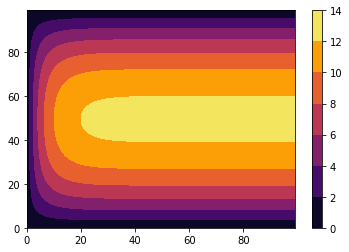

In [3]:
Lx=5
Ly=1
Nx=100
Ny=100
vis= 10e-6
vl = np.array([5,-2])
vt = np.array([0,0])
vr = np.array([0,0])
vb = np.array([0,0])
gradP = np.array([-1,0])
rho = 997
v,vmag=CFD(Lx,Ly,Nx,Ny,vis,vl,vr,vt,vb,rho,gradP)


## VTK Format


In [4]:
from pathlib import Path
dir_vtk = Path("vtkFiles")
dir_vtk.mkdir(parents=True, exist_ok=True)


In [5]:
preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
Nz = 1
dx = Lx/Nx
dy = Ly/Ny
ycoord = np.arange(0,Ly+dy,dy, dtype=float)
xcoord = np.arange(0,Lx+dx,dx, dtype=float)
zcoord = np.array([0,1])
fname = 'standardVtk.vtk'
with open(dir_vtk/fname, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(Nx+1,Ny+1,Nz))
        f.write('POINTS %i float\n' %((Nx+1)*(Ny+1)))
        count = 0
            
        for y in ycoord:
            for x in xcoord:
#                 count+=1
                f.write('%f %f 0.0 \n' %(x,y))
                
        f.write('CELL_DATA %i\n'%((Nx)*(Ny)))
        f.write('SCALARS VelocityMag float 1\nLOOKUP_TABLE default\n')
        for vel in vmag:
            f.write('%f\n'%vel)
            
        f.write('VECTORS Velocity float 3\nLOOKUP_TABLE default\n')
        for i in range(0,len(v),2):
             f.write('%f %.1f 0.0\n'%(v[i],abs(v[i+1])))